In [ ]:
# !unzip in_data/data-compressed.zip

In [ ]:
#imports, need to only run this once
!pip3 install numpy 
!pip3 install pandas 
!pip3 install torch torchvision 
!pip3 install scikit-learn
!pip3 install xgboost
!pip3 install category_encoders
!pip3 install shap

# GRADIENT BOOSTED TREE (GBT) + Some Exploratory Work

In [5]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split

D_PATH = 'lish-moa/'

train_features = pd.read_csv(D_PATH + 'train_features.csv')
train_drug  = pd.read_csv(D_PATH + 'train_drug.csv')
test_features = pd.read_csv(D_PATH + 'test_features.csv')
train_targets_scored = pd.read_csv(D_PATH + 'train_targets_scored.csv' )
train_targets_nonscored = pd.read_csv(D_PATH + 'train_targets_nonscored.csv' )

tr_mask = train_features['cp_type']=='ctl_vehicle'
ts_mask = test_features['cp_type']=='ctl_vehicle'



#manually binarizing the category labels that are strings
train_features['cp_dose'] = train_features['cp_dose'].replace({'D1': 0, 'D2': 1})
train_features['cp_type'] = train_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})
test_features['cp_dose'] = test_features['cp_dose'].replace({'D1': 0, 'D2': 1})
test_features['cp_type'] = test_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})

# Exclude rows where cp_type is "ctl_vehicle"
COMPLETE_X = train_features[~tr_mask]
COMPLETE_y = train_targets_scored[~tr_mask]


#removing sig_id column, will also remove column header
X = COMPLETE_X.iloc[:, 1:].to_numpy()
submission_X_test = test_features.iloc[:, 1:].to_numpy() #only for the final submission
y = COMPLETE_y.iloc[:, 1:].to_numpy()

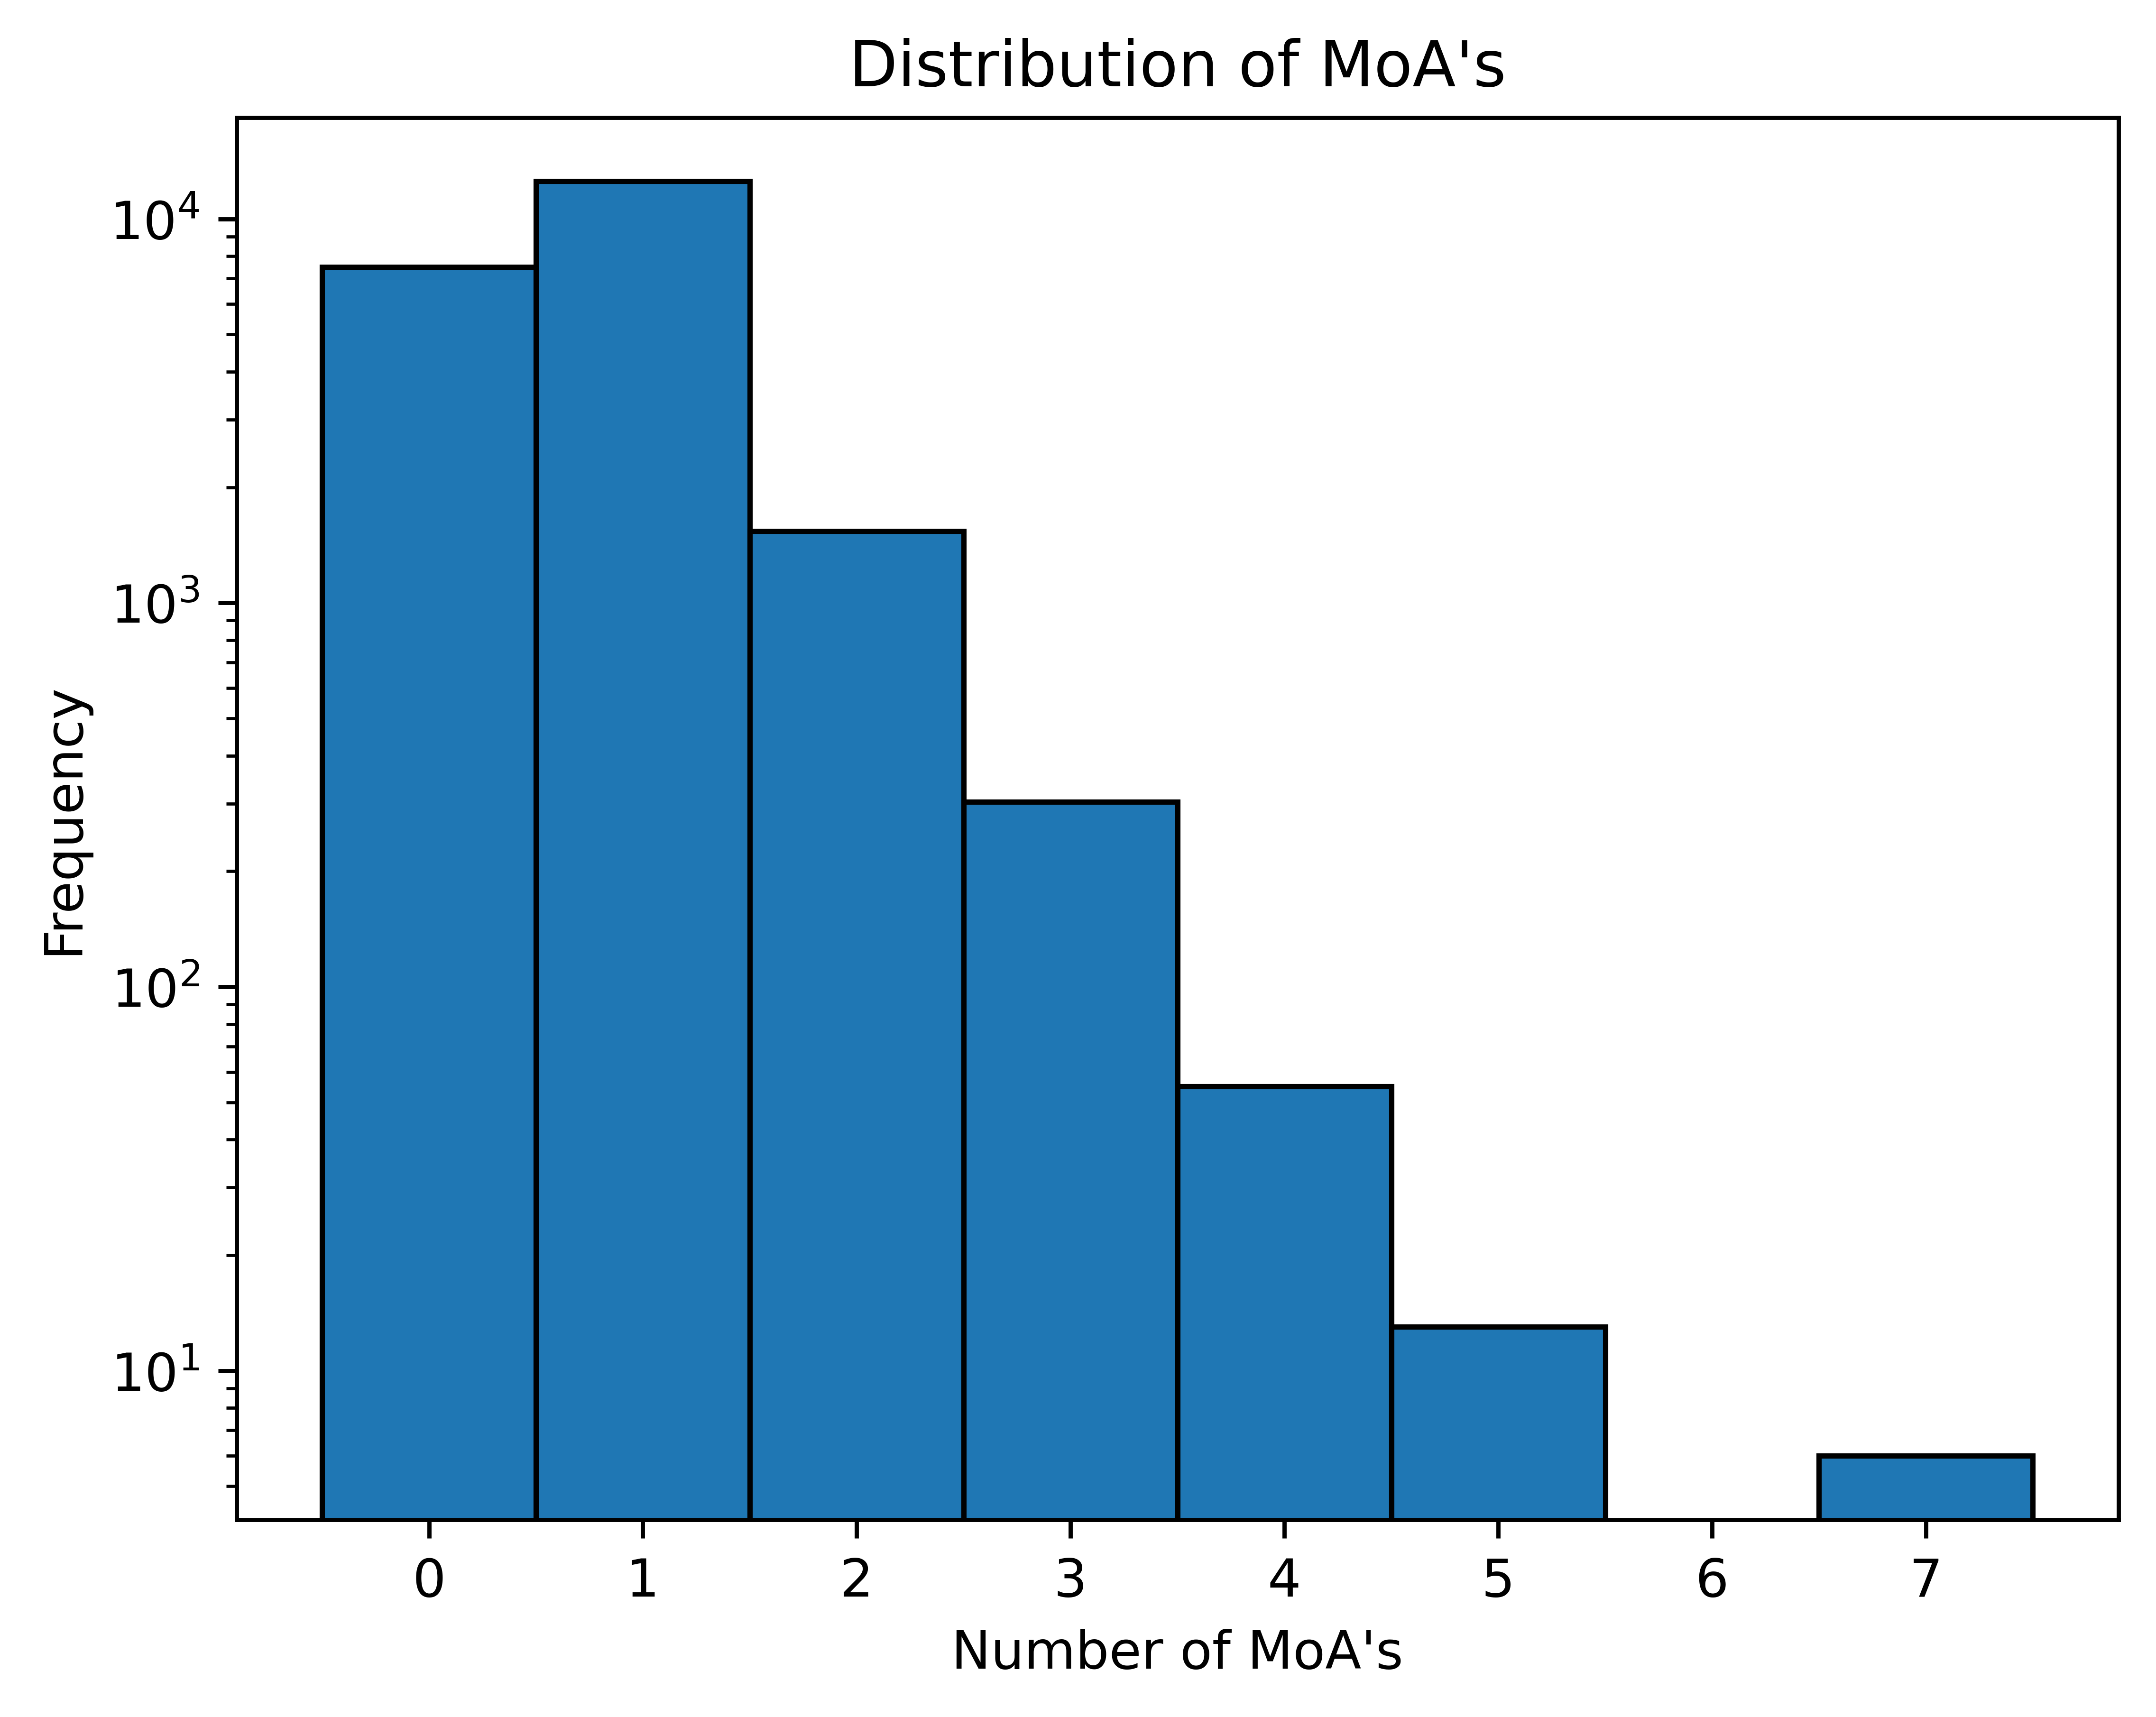

In [9]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

f = plt.figure(dpi=800)
disp_y = COMPLETE_y.iloc[:, 1:].to_numpy()
row_sums = np.sum(disp_y, axis=1)

# Plot the distribution
plt.hist(row_sums, bins=np.arange(9)-0.5, align='mid', edgecolor='black')
plt.xlabel('Number of MoA\'s' )
plt.ylabel('Frequency')
plt.title('Distribution of MoA\'s')
plt.yscale('log')
plt.xticks(range(8))
plt.show()

In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd 

f = plt.figure(dpi=800)
plt.matshow(np.triu(COMPLETE_X.corr()), fignum=f.number, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 10), dpi=800) #create figure object with high DPI because there are lots of column labels 

col_sums = COMPLETE_y.sum(axis=0).iloc[1:].sort_values() #take col sums to find number of examples 

print(f'min count: {col_sums.min()}, max count: {col_sums.max()}') #output min and max count of labels

col_sums.plot.bar(ylabel='label_count', fontsize=2) #plot
plt.yticks(fontsize=8)
plt.yscale('log')


### Vanilla GBT 

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split


D_PATH = 'lish-moa/'

train_features = pd.read_csv(D_PATH + 'train_features.csv')
train_drug  = pd.read_csv(D_PATH + 'train_drug.csv')
test_features = pd.read_csv(D_PATH + 'test_features.csv')
train_targets_scored = pd.read_csv(D_PATH + 'train_targets_scored.csv' )
train_targets_nonscored = pd.read_csv(D_PATH + 'train_targets_nonscored.csv' )

tr_mask = train_features['cp_type']=='ctl_vehicle'
ts_mask = test_features['cp_type']=='ctl_vehicle'



#manually binarizing the category labels that are strings
train_features['cp_dose'] = train_features['cp_dose'].replace({'D1': 0, 'D2': 1})
train_features['cp_type'] = train_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})
test_features['cp_dose'] = test_features['cp_dose'].replace({'D1': 0, 'D2': 1})
test_features['cp_type'] = test_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})

# Exclude rows where cp_type is "ctl_vehicle"
COMPLETE_X = train_features[~tr_mask]
COMPLETE_y = train_targets_scored[~tr_mask]


#removing sig_id column, will also remove column header
X = COMPLETE_X.iloc[:, 1:].to_numpy()
submission_X_test = test_features.iloc[:, 1:].to_numpy() #only for the final submission
y = COMPLETE_y.iloc[:, 1:].to_numpy()

#we are going to fake making a train, dev and test set 
'''
X -> training examples, 
X_test -> 30% of samples, is used in next line to further split into dev, 
y -> training labels, 
y_test -> used to split into dev
'''
X, X_test, y, y_test = train_test_split(X, y, test_size=0.8, random_state=42) 
# X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.333, random_state=42) #test_size is dev size of 0.3333

In [ ]:
import numpy as np 
import pandas as pd 

# to filter by num of MoA's 
def filter_matrices_greater_than(x, y, k):
    y_row_sums = np.sum(y, axis=1)
    indices = np.where(y_row_sums >= k)[0]
    p = x[indices]
    q = y[indices]
    return p, q

def filter_matrices_less_than(x, y, k):
    y_row_sums = np.sum(y, axis=1)
    indices = np.where(y_row_sums <= k)[0]
    p = x[indices]
    q = y[indices]
    return p, q


temp_x = COMPLETE_X.iloc[:, 1:].to_numpy()
temp_y = COMPLETE_y.iloc[:, 1:].to_numpy()
k = 3

filtered_l_x, filtered_l_y = filter_matrices_less_than(temp_x, temp_y, k) #ex. k=2, only look at where less than 2 labels are there, you can alternatively only do this on the test set
print(f'Number of samples with {k} or less labels: {filtered_l_x.shape[0]}')

filtered_g_x, filtered_g_y = filter_matrices_greater_than(temp_x, temp_y, k) #ex. k=3, only look at where 3 or more labels are there, you can alternatively only do this on the test set
print(f'Number of samples with {k} or more labels: {filtered_g_x.shape[0]}')

In [ ]:
#testing on the filtered dataset
test_preds = model.predict_proba(filtered_g_x) #get predictions on test set
test_preds = np.array(test_preds)[:,:,1].T # take the positive class 
mat_y_preds = np.round(test_preds)

report = classification_report(np.ravel(filtered_g_y), np.round(np.ravel(test_preds)))

print('*'*20 + "FILTERED RESULTS" + '*'*20)
print(report)

In [ ]:
import shap 

#shap plot 
explainer = shap.TreeExplainer(model.named_steps['classify'].estimators_[87])
df_X = pd.DataFrame(X, columns=COMPLETE_X.columns[1::])
shap_values = explainer(df_X)
plt.figure(dpi=800)
shap.summary_plot(shap_values, X, show=False)
plt.figure(dpi=800)
shap.summary_plot(shap_values, df_X.values, plot_type="bar", class_names= df_X.columns, feature_names = df_X.columns)

In [3]:
import os 
import sys
import numpy as np 
import pandas as pd 
from xgboost import XGBClassifier 
from sklearn.model_selection import KFold, RandomizedSearchCV 
from category_encoders import CountEncoder 
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score, classification_report, jaccard_score, make_scorer, balanced_accuracy_score
from sklearn.multioutput import MultiOutputClassifier
import joblib 


n_folds = 8 #num folds for Kfold cross validation


'''
NO HYPERPARAMETER TUNING
- we use just vanilla kfold cv with default hyperparameters 
'''
xgb_classifier = MultiOutputClassifier(XGBClassifier()) #using sklearn's pipeline to build a multilabel, multiclass classifier
model = Pipeline([ 
                  ('classify', xgb_classifier)]) #instantiate the pipeline object

kf = KFold(n_splits = n_folds) #instantiate a kfold CV object 



oof_losses = []
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'fold: {fold_idx}')
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
   # Fit RandomizedSearchCV on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    val_preds = model.predict_proba(X_val)
    
    val_preds = np.array(val_preds)[:,:,1].T # take the positive class

    loss = log_loss(np.ravel(y_val), np.ravel(val_preds)) #using log loss here not jaccard
    print(f'loss: {loss}')

    oof_losses.append(loss)

joblib.dump(model, 'model-003-log-loss.pkl')
#try on test set 
test_preds = model.predict_proba(X_test) #get predictions on test set
test_preds = np.array(test_preds)[:,:,1].T # take the positive class 
mat_y_preds = np.round(test_preds)

report = classification_report(np.ravel(y_test), np.round(np.ravel(test_preds)))
print(report)

report = classification_report(np.ravel(y_test), np.round(np.ravel(test_preds)))
balanced_score = balanced_accuracy_score(np.ravel(y_test), np.round(np.ravel(test_preds)))

print(f"Balanced Accuracy Score: {balanced_score:.2f}\n")
print("Classification Report")
print(report)

fold: 0
loss: 0.02381562650048329
fold: 1
loss: 0.02437359653736463
fold: 2
loss: 0.02445569754926001
fold: 3
loss: 0.023402136759907516
fold: 4
loss: 0.023843872255325728
fold: 5
loss: 0.02327726473459224
fold: 6
loss: 0.02375379115293028
fold: 7
loss: 0.02329327666210759
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3603708
           1       0.94      0.17      0.30     13446

    accuracy                           1.00   3617154
   macro avg       0.97      0.59      0.65   3617154
weighted avg       1.00      1.00      1.00   3617154

Balanced Accuracy Score: 0.59

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3603708
           1       0.94      0.17      0.30     13446

    accuracy                           1.00   3617154
   macro avg       0.97      0.59      0.65   3617154
weighted avg       1.00      1.00      1.00   3617154



## Random Search CV GBT

In [19]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split


'''
Same pre-processing code as above if needed
'''

D_PATH = 'lish-moa/'

train_features = pd.read_csv(D_PATH + 'train_features.csv')
train_drug  = pd.read_csv(D_PATH + 'train_drug.csv')
test_features = pd.read_csv(D_PATH + 'test_features.csv')
train_targets_scored = pd.read_csv(D_PATH + 'train_targets_scored.csv' )
train_targets_nonscored = pd.read_csv(D_PATH + 'train_targets_nonscored.csv' )

tr_mask = train_features['cp_type']=='ctl_vehicle'
ts_mask = test_features['cp_type']=='ctl_vehicle'



#manually binarizing the category labels that are strings
train_features['cp_dose'] = train_features['cp_dose'].replace({'D1': 0, 'D2': 1})
train_features['cp_type'] = train_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})
test_features['cp_dose'] = test_features['cp_dose'].replace({'D1': 0, 'D2': 1})
test_features['cp_type'] = test_features['cp_type'].replace({'trt_cp': 0, 'ctl_vehicle': 1})

# Exclude rows where cp_type is "ctl_vehicle"
COMPLETE_X = train_features[~tr_mask]
COMPLETE_y = train_targets_scored[~tr_mask]


#removing sig_id column, will also remove column header
X = COMPLETE_X.iloc[:, 1:].to_numpy()
submission_X_test = test_features.iloc[:, 1:].to_numpy() #only for the final submission
y = COMPLETE_y.iloc[:, 1:].to_numpy()

#we are going to fake making a train, dev and test set 
'''
X -> training examples, 
X_test -> 30% of samples, is used in next line to further split into dev, 
y -> training labels, 
y_test -> used to split into dev
'''
X, X_test, y, y_test = train_test_split(X, y, test_size=0.8, random_state=42) 
# X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.333, random_state=42) #test_size is dev size of 0.3333

In [32]:
'''
- parameter grid, we elect to modify the max_depth, learning_rate and n_estimators 
'''

'''GBT WITH HYPERPARAMETER TUNING'''
import os 
import sys
import numpy as np 
import pandas as pd 
import joblib #save best model 
from xgboost import XGBClassifier 
from sklearn.model_selection import KFold, RandomizedSearchCV 
from category_encoders import CountEncoder 
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score, classification_report, jaccard_score, make_scorer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score



param_grid = {
    'classify__estimator__max_depth': np.linspace(4, 11, 7).astype(int),
    'classify__estimator__learning_rate': [10 ** -i for i in range(1, 4)],
    'classify__estimator__n_estimators': [i*100 for i in range(1, 5)]
}

def custom_log_loss(y_true, y_pred):
    y_true_flat = np.ravel(y_true)
    test_preds = np.array(y_pred)[:,:,1].T #take positive class
    y_pred_flat = np.ravel(np.round(test_preds))
    return -1 * log_loss(y_true_flat, y_pred_flat)

n_folds = 4
n_iters = 50

xgb_classifier = MultiOutputClassifier(XGBClassifier()) #using sklearn's pipeline to build a multilabel, multiclass classifier

model = Pipeline([ 
                  ('classify', xgb_classifier)]) #instantiate the pipeline object

kf = KFold(n_splits = n_folds) #instantiate a kfold CV object 

'''
- We use random_search to not explore the whole parameter space, n_iter gives the number of param combinations used, can alternatively use GridSearchCV
- Jaccard scoring appears to be a good metric for a multilabel multiclass problem, can read more at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
''' 

jaccard_scorer = make_scorer(jaccard_score, average='macro', zero_division=0.0) #define custom scoring function
log_loss_scorer = make_scorer(custom_log_loss, greater_is_better=False, needs_proba=True)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iters, cv=kf, scoring=log_loss_scorer, verbose=2, n_jobs=-1)
random_search.fit(X, y)# Fit RandomizedSearchCV on the training data
best_model = random_search.best_estimator_ # Get the best model from RandomizedSearchCV

joblib.dump(best_model, 'model-002-log-loss.pkl')

test_preds = best_model.predict_proba(X_test) #get predictions on test set
test_preds = np.array(test_preds)[:,:,1].T # take the positive class 

report = classification_report(np.ravel(y_test), np.round(np.ravel(test_preds)))
balanced_score = balanced_accuracy_score(np.ravel(y_test), np.round(np.ravel(test_preds)))

print(f"Balanced Accuracy Score: {balanced_score:.2f}\n")
print("Classification Report")
print(report)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV] END classify__estimator__learning_rate=0.01, classify__estimator__max_depth=5, classify__estimator__n_estimators=100; total time= 8.3min
[CV] END classify__estimator__learning_rate=0.01, classify__estimator__max_depth=5, classify__estimator__n_estimators=100; total time= 8.4min
[CV] END classify__estimator__learning_rate=0.01, classify__estimator__max_depth=5, classify__estimator__n_estimators=100; total time= 8.4min
[CV] END classify__estimator__learning_rate=0.01, classify__estimator__max_depth=5, classify__estimator__n_estimators=100; total time= 8.4min
[CV] END classify__estimator__learning_rate=0.1, classify__estimator__max_depth=1, classify__estimator__n_estimators=100; total time= 3.4min
[CV] END classify__estimator__learning_rate=0.1, classify__estimator__max_depth=1, classify__estimator__n_estimators=100; total time= 3.4min
[CV] END classify__estimator__learning_rate=0.1, classify__estimator__max_depth=1, class

/Users/neeltangella/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classify__estimator__learning_rate=0.1, classify__estimator__max_depth=7, classify__estimator__n_estimators=100; total time= 6.7min
[CV] END classify__estimator__learning_rate=0.1, classify__estimator__max_depth=7, classify__estimator__n_estimators=100; total time= 6.7min
[CV] END classify__estimator__learning_rate=0.1, classify__estimator__max_depth=7, classify__estimator__n_estimators=100; total time= 6.7min
[CV] END classify__estimator__learning_rate=0.001, classify__estimator__max_depth=5, classify__estimator__n_estimators=400; total time=28.2min
[CV] END classify__estimator__learning_rate=0.001, classify__estimator__max_depth=5, classify__estimator__n_estimators=400; total time=28.2min
[CV] END classify__estimator__learning_rate=0.001, classify__estimator__max_depth=5, classify__estimator__n_estimators=400; total time=28.4min
[CV] END classify__estimator__learning_rate=0.001, classify__estimator__max_depth=5, classify__estimator__n_estimators=400; total time=28.7min
[CV] 

/Users/neeltangella/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/neeltangella/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/neeltangella/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced Accuracy Score: 0.50

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3603708
           1       0.00      0.00      0.00     13446

    accuracy                           1.00   3617154
   macro avg       0.50      0.50      0.50   3617154
weighted avg       0.99      1.00      0.99   3617154



OPTIMAL MODEL STATISTICS: num_estimators: 200, max_depth: 2, learning_rate: 0.1


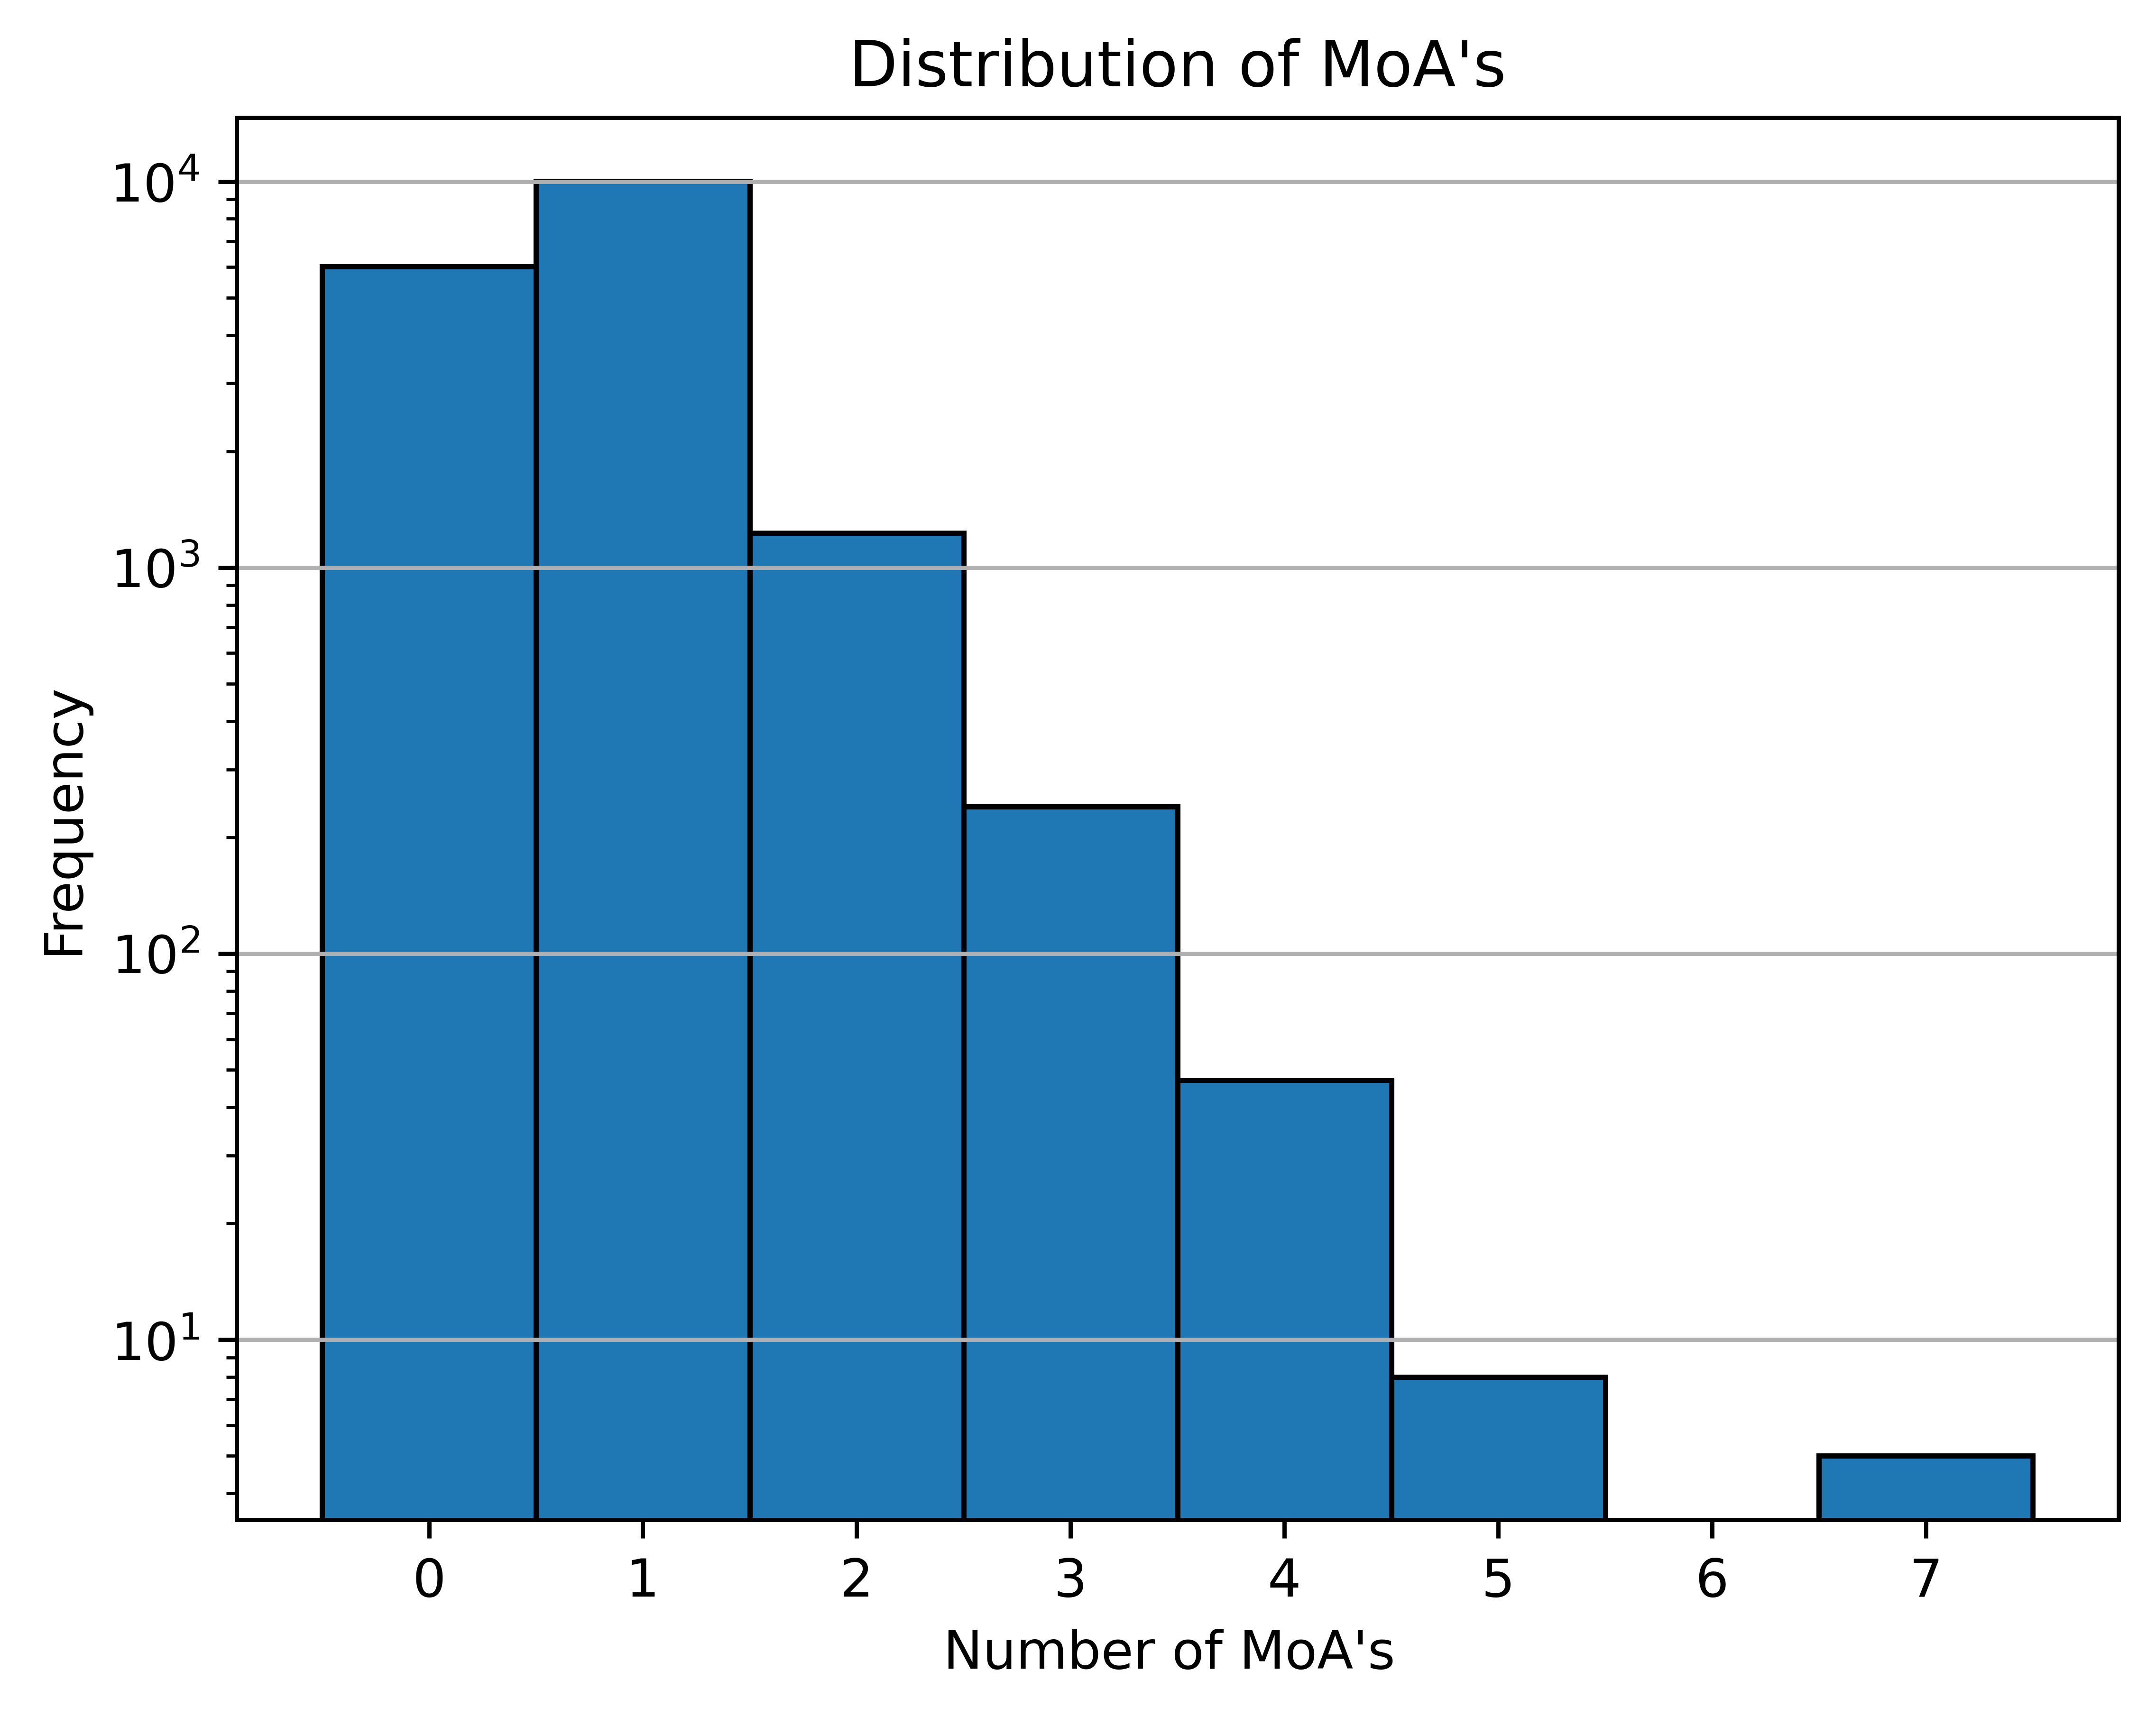

Log Loss:  0.049
Balanced Accuracy Score: 0.59

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3603708
           1       0.94      0.18      0.31     13446

    accuracy                           1.00   3617154
   macro avg       0.97      0.59      0.65   3617154
weighted avg       1.00      1.00      1.00   3617154



In [24]:
#LOAD MODEL 
import joblib
import matplotlib.pyplot as plt 
from sklearn.metrics import log_loss

model_jaccard_1 = joblib.load('model-001-jaccard.pkl')
params = model_jaccard_1.named_steps['classify'].get_params()
num_estimators = params['estimator__n_estimators']
max_depth = params['estimator__max_depth']
lr = params['estimator__learning_rate']
print(f'OPTIMAL MODEL STATISTICS: num_estimators: {num_estimators}, max_depth: {max_depth}, learning_rate: {lr}')

test_preds = model_jaccard_1.predict_proba(X_test) #get predictions on test set
test_preds = np.array(test_preds)[:,:,1].T # take the positive class 
# row_sums = np.sum(np.round(test_preds), axis=1)
row_sums = np.sum(y_test, axis=1)

# Plot the distribution
plt.figure(dpi=800)
plt.hist(row_sums, bins=np.arange(9)-0.5, align='mid', edgecolor='black')
plt.xlabel('Number of MoA\'s ')
plt.ylabel('Frequency')
plt.title('Distribution of MoA\'s')
plt.yscale('log')
plt.xticks(range(8))
plt.grid(axis='y')  # Add gridlines for clarity
plt.savefig('dist-test-set.png')
plt.show()

l_loss = log_loss(np.ravel(y_test), np.round(np.ravel(test_preds)))
print(f'Log Loss: {l_loss: .3f}')

report = classification_report(np.ravel(y_test), np.round(np.ravel(test_preds)))
balanced_score = balanced_accuracy_score(np.ravel(y_test), np.round(np.ravel(test_preds)))

print(f"Balanced Accuracy Score: {balanced_score:.2f}\n")
print("Classification Report")
print(report)
